In [100]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from math import sqrt

#plots
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel

# sklearn
from sklearn.svm import LinearSVC
from sklearn.exceptions import DataConversionWarning; import warnings
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV

In [62]:
# load data
data = pd.read_csv('preprced.csv')
data = data.dropna()
data = data.reset_index()

In [63]:
data['set'] = 'hi'

In [64]:
data['set'][:3500] = 'test'
data['set'][3500:] = 'train'

C:\Users\Jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
df_train = data[data.set=="train"]
df_test = data[data.set=="test"]

In [68]:
X = data['title']
y = data['comments']
# create test, train and dev
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)    
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [69]:
X_test_split = [sent.split(' ') for sent in X_test]

In [70]:
# Bag of Words

# CountVectorizer has a build-in tokenizer and lowercases by default. Also has an option to remove stopwords.
vectorizer = CountVectorizer()
# However, you can override the default tokenization with your own defined function, like so:
#vectorizer = CountVectorizer(tokenizer=preprocess)

# fit and transform train
X_train_bow = vectorizer.fit_transform(data.title.values)
# Only tranform test: never fitting your vectorizer on the test set (it is cheating). OOV words are handled automatically be sklearn's vectorizer.
X_test_bow = vectorizer.transform(df_test.title.values)

In [71]:
print(X_train_bow.shape)
print(len(vectorizer.vocabulary_))
X_train_bow[0]

(7144, 9604)
9604


<1x9604 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [72]:
X_train_bow[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [73]:
def make_ngrams(sentence,n):
    tokens = sentence.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


In [74]:
# n=1-5
vectorizer = CountVectorizer(ngram_range=(1,5))

X_train_5gram = vectorizer.fit_transform(df_train.title.values)

In [75]:
print(X_train_5gram.shape)
X_train_5gram[0]

(3644, 64114)


<1x64114 sparse matrix of type '<class 'numpy.int64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [76]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train.title.values)

In [77]:
X_train_tfidf[1]

<1x6340 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [78]:
distance.cosine(X_train_tfidf[0].toarray(), X_train_tfidf[1].toarray())

1.0

In [79]:
X_train

1439        Prins Charles er stadig mærket af coronavirus
60               Dansk skuespillerinde scorer kæmpe rolle
2974                                    Dansk komet lyner
201     DF: Der er allerede aftale om gratis mundbind ...
1690                       Hård straf for skør coronajoke
                              ...                        
4355    Forening kræver kompensation for hjemsendte di...
4048    Tyskere demonstrerer mod tab af rettigheder un...
4600    Op mod hver tiende negative coronatest kan vær...
4153      Storbritannien melder om 763 nye coronadødsfald
1552        Her er udbetaling af feriepenge en dårlig ide
Name: title, Length: 2381, dtype: object

In [80]:
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
cosine_similarities = linear_kernel(X_train_tfidf[0], X_train_tfidf).flatten()

indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])

most similar: [   0 3184  287 2475   52 2007 2023 3526  227 3363]
least similar [2262 2260 2259 2258 2257 2256 2255 2254 1821]


In [81]:
print(df_train.title.values[0])
print()
print("most similar: ", df_train.title.values[1719])
print()
print("least similar: ", df_train.title.values[7237])

Miljøminister sætter kommuner på plads i strid om Bakken

most similar:  Undrer sig over nyt program: - Det lyder vanvittigt



IndexError: index 7237 is out of bounds for axis 0 with size 3644

# Vector space models

In [82]:
from gensim.models import Word2Vec

# using the train_sents from earlier (the lowercased and tokenized sentences)
model = Word2Vec(X_test_split, size=100, min_count = 10, workers = 2) 

In [83]:
print(model.build_vocab)

<bound method BaseWordEmbeddingsModel.build_vocab of <gensim.models.word2vec.Word2Vec object at 0x000001F3F11E34C8>>


In [84]:
for i, word in enumerate(model.wv.vocab):
    if i == 100:
        break
    print(word)

største
og
på
over
dansk
om
-
Efter
klar
til
comeback
efter
København
er
et

af
nye
fortsætter
mod
Regeringen
for
Coronavirus
sender
skal
med
slår
FCK
i
bliver
Danmark
Mette
os
har
det
Der
kan
to
City
USA
Jeg
Bayern
sætter
rekord
ny
hjem
fra
New
York
sin
I
Første
danske
nyt
at
Nu
ikke
blev
Kæmpe
Sverige
registrerer
smittede
en
går
alle
mundbind
Aarhus
Kina
Medie:
klub
var
år
smittet
coronavirus
tæt
Tyskland
antal
vinder
FC
stopper
WHO
døgn
Officielt:
henter
vil
åbne
Eriksen
fire
sig
Trump
Dansk
må
mere
Ny
Danske
får
uge
Venstre
nu
Vi


In [85]:
model

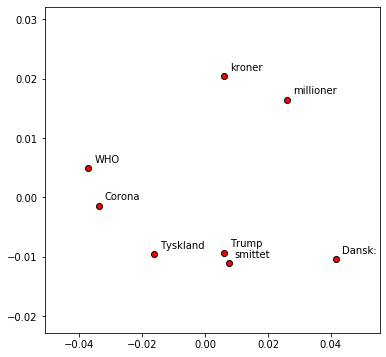

In [98]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ['Corona', 'Tyskland', 'Dansk:', 'kroner', 'Trump', 'WHO', 'millioner', 'smittet']

X = [model.wv['Corona'], model.wv['Tyskland'], 
     model.wv['Dansk'], model.wv['kroner'],
     model.wv['Trump'], model.wv['WHO'], 
     model.wv['millioner'], model.wv['smittet']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.002, y+0.001, word)

# model

In [ ]:
np.logspace(-4, 4, 12)

In [ ]:
PolynomialFeatures.get_params()

In [ ]:
# SOLUTION
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0)),
])

param_grid = {"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
             "tfidf__use_idf": [True, False]
             }

search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, verbose=10, n_jobs = 2)

search.fit(df_train.title.values, df_train.comments.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   33.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 22.3min
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed: 27.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed: 27.9min finished


In [ ]:
print('Best parameter set: %s ' % search.best_params_) 

In [ ]:
# SOLUTION
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(degree=2, include_bias=False)),
])

param_grid = {"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
             "tfidf__use_idf": [True, False],
              'pol_alpha': [np.logspace(-4, 4, 12)]
             }

search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, verbose=10, n_jobs = 4)

search.fit(df_train.title.values, df_train.comments.values)

In [111]:
output = []
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
pipeline = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True)),
                     ('selectkbest', SelectKBest()),
                     ('linearscv', LinearSVC(max_iter=10000, dual=False))])
#clf.fit(X_train, y_train)
#clf.predict(X_test)


In [83]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'linearsvc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'linearsvc__C', 'linearsvc__class_weight', 'linearsvc__dual', 'linearsvc__fit_intercept', 'linearsvc__intercept_scaling', 'linearsvc__loss', 'linearsvc__max_iter', 'linearsvc__multi_class', 'linearsvc__penalty', 'linearsvc__random_state', 'linearsvc__tol', 'linearsvc__verbose'])

In [87]:
penalties.remove(0)

In [88]:
X_test = [list(range(100))]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [122]:
penalties = list(range(20))
penalties.remove(0)
grid = {
    'tfidf__ngram_range':[(1,2),(2,3)],
    'tfidf__stop_words': [None, 'english'],
    'selectkbest__k': [10000, 15000],
    'selectkbest__score_func': [f_classif, chi2],
    'linearscv__penalty': ['l1', 'l2'] }
    
#gs = GridSearchCV(estimator=clf, 
#                  param_grid=grid, 
#                  scoring='neg_mean_squared_error', cv=10,  n_jobs=-1)

gs = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=-1, cv=5)
gs.fit(X = X_test, y = y_test)

C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


ValueError: Found input variables with inconsistent numbers of samples: [2, 167]

In [115]:
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
#make_pipeline(steps=[('standardscaler', StandardScaler()), ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [77]:
output

[[29985.215568862277, 53682.113772455086]]